In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
import torch
from train_pixart_controlnet_hf import load_pretrained, load_data, masktensor_to_colorimage, make_image_grid
import json
from pathlib import Path
from torchvision import transforms


/USERSPACE/lukovdg1/venvs/sd3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
EXPDIR = Path("/USERSPACE/lukovdg1/pixart-sigma/train_scripts/control_experiments_v2/pixart_coco_simpleadapters/")
pipe, tokenizer, _, args = load_pretrained(EXPDIR, device=torch.device("cuda:3"))

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


torch.Size([1, 512, 64, 64])


/USERSPACE/lukovdg1/pixart-sigma/train_scripts/train_pixart_controlnet_hf.py:587: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  controlencoder2.load_state_dict(torch.load(Pa

Loading from:  /USERSPACE/lukovdg1/pixart-sigma/train_scripts/control_experiments_v2/pixart_coco_simpleadapters/saved-50000


/USERSPACE/lukovdg1/pixart-sigma/train_scripts/train_pixart_controlnet_hf.py:610: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(savedpaths[0] / "controlnet_w

loaded pipeline components, loading pipeline


Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


In [4]:
ds, dl = load_data(args, tokenizer, split="val")

loading captions
loading instances
Creating examples


100%|██████████| 5000/5000 [00:00<00:00, 272814.46it/s]

Size stats:
{384: 1937, 448: 1792, 512: 343}
Retained examples: 3342
Too many regions: 121
Too few regions: 609
Too small: 928


In [5]:
pipe.device
pipe.to(pipe.device)
pipe.transformer.device

device(type='cuda', index=3)

100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


0 A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.


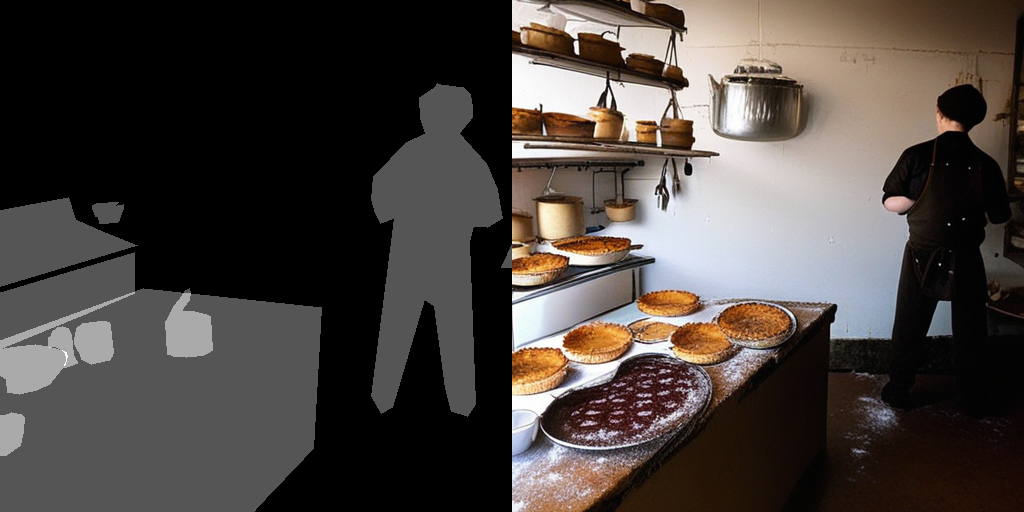

100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


1 People walking past a homeless man begging on a city street


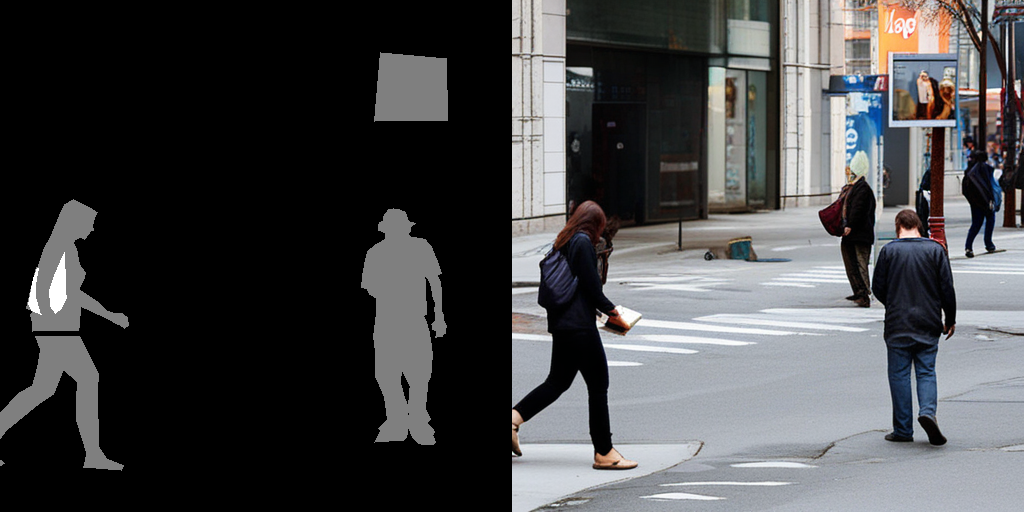

100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


2 A bicycle is locked up to a post


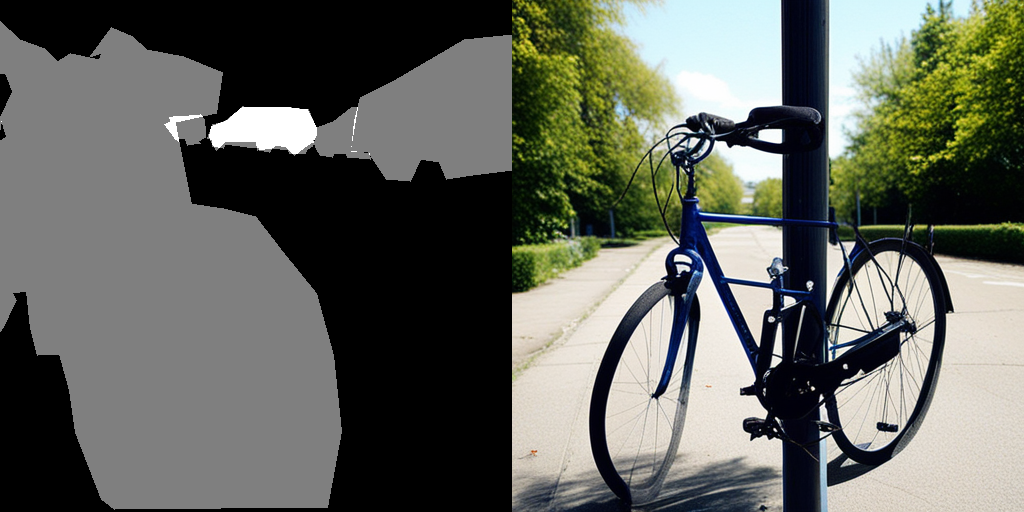

100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


3 There is a row of used and broken toilets in a field.


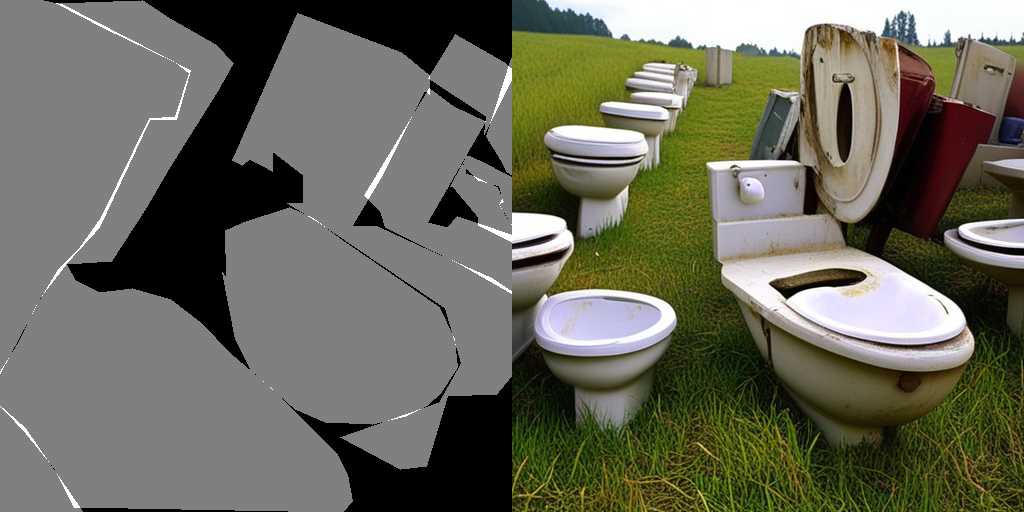

100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


4 People are walking and riding motorcycles on the street


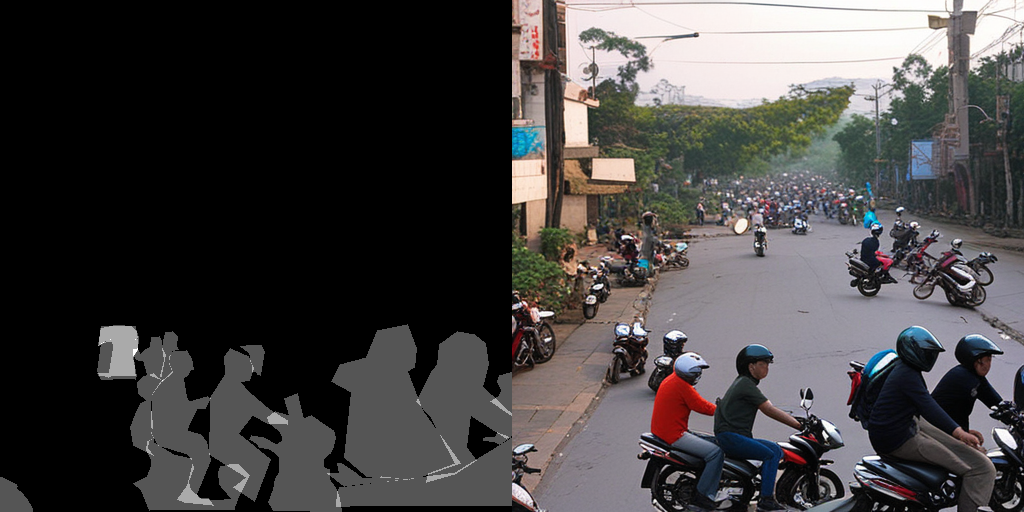

In [6]:
seed = 42
maxex = 5
device = pipe.device


generator = torch.Generator(device=device)
if seed is not None:
    generator = generator.manual_seed(seed)
images = []
cond_images = []
captions = []


i = 0
while i < maxex:
    example = ds[i]
    images.append(
        pipe(example["captions"][0], control_image=example["cond_image"][None].to(device), num_inference_steps=20, generator=generator, height=512, width=512).images[0])
    # cond_images.append(transforms.ToPILImage()(masktensor_to_colorimage(example["cond_image"])))
    sumimg = example["cond_image"].float().sum(0, keepdims=True)
    cond_images.append(transforms.ToPILImage()( sumimg / sumimg.max()))
    captions.append(example["captions"][0])
    print(i, captions[-1])
    display(make_image_grid([cond_images[-1], images[-1]], 1, 2))
    i += 1
    if i >= maxex:
        break

In [ ]:
for i in range(len(images)):
    print(i)
    print(captions[i])
    display(make_image_grid(cond_images[i:i+1] + images[i:i+1], 1, 2))

In [8]:
import random
import re
import pickle

examples = pickle.load(open("/USERSPACE/lukovdg1/controlnet11/evaldata/extradev_importless.pkl", "rb"))
x = examples[0]
x

caption = x["captions"][0]
segten = (transforms.ToTensor()(x["seg_data"]) * 255).to(torch.long)
segten = segten[0] + segten[1] * 256 + segten[2] * 256**2
print(segten.unique())


objmasks = torch.zeros((21,) + segten.shape).to(segten.device, torch.bool)
objlayerids = list(range(len(objmasks)))
random.shuffle(objlayerids)
captions = [None for _ in range(len(objlayerids))]
for colorid in segten.unique():
    # get mask and store in variable
    mask = segten == colorid
    layerid = objlayerids.pop(0)
    objmasks[layerid] = mask
    # get description from global dense prompt and store it
    found = re.findall(r"\{([^:]+):" + str(colorid.item()) + "\}", caption)
    assert(len(found) == 1)
    captions[layerid] = found[0]
    # print(found)
    # display(transforms.ToPILImage()(mask.to(torch.float)))
    
print(captions)
print(objmasks.shape)
print(objmasks.sum(-1).sum(-1))
    

tensor([ 3584971,  5633996,  7069951, 10236894])
[None, 'a gold coin', None, None, 'a red tennis ball', None, None, None, None, None, 'a blue crystal ball', None, None, None, None, None, None, None, None, None, 'a wooden table']
torch.Size([21, 512, 512])
tensor([     0,   4141,      0,      0,  23821,      0,      0,      0,      0,
             0,  58680,      0,      0,      0,      0,      0,      0,      0,
             0,      0, 175502])


a gold coin. a red tennis ball. a blue crystal ball. a wooden table


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


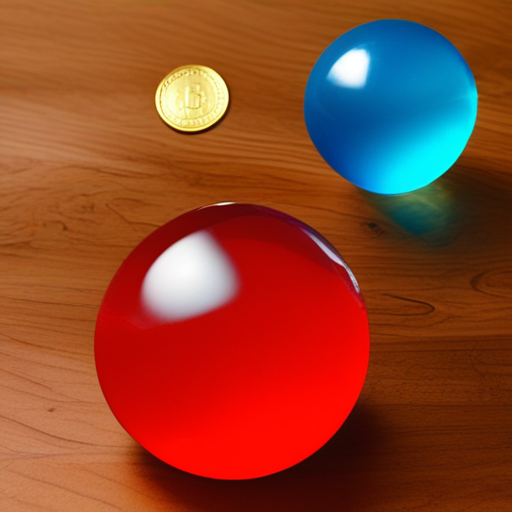

In [12]:
prompt = ". ".join([x for x in captions if x is not None])
print(prompt)
img = pipe(prompt=prompt, control_image=objmasks[None].to(device, torch.long), 
                num_inference_steps=20, generator=generator, height=512, width=512).images[0]
display(img)